In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep
hep.style.use("CMS")
import glob, re, sys
sys.path.append('/t3home/gcelotto/ggHbb/NN')
from functions import loadMultiParquet, cut, getXSectionBR
from helpersForNN import preprocessMultiClass, scale, unscale
from applyMultiClass_Hpeak import getPredictions, splitPtFunc
sys.path.append("/t3home/gcelotto/ggHbb/scripts/plotScripts")
from plotFeatures import plotNormalizedFeatures

In [2]:
# Load data in df and dfData
pTClass, nReal, nMC = 0, 300, -1
paths = [
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/Data1A/",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/GluGluHToBB/",
            ]
isMCList = [0, 1]

# load the files where the prediction is available

# get predictions
pathToPredictions = "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/NNpredictions"
fileNumberList = []
for isMC in isMCList:
    fileNumberProcess = []
    fileNamesProcess = glob.glob(pathToPredictions+"/yMC%d_fn*pt%d*.parquet"%(isMC, pTClass))
    for fileName in fileNamesProcess:
        match = re.search(r'_fn(\d+)_pt', fileName)
        if match:
            fn = match.group(1)
            fileNumberProcess.append(int(fn))
            
        else:
            pass
            #print("Number not found")
    fileNumberList.append(fileNumberProcess)
    print(len(fileNumberProcess), " predictions files for process MC : ", isMC)


columns= ['sf',         'dijet_mass',   'jet1_pt',      'jet2_pt',
          'jet1_mass',  'jet2_mass',    'jet1_eta',     'jet2_eta',
          'jet1_qgl',   'jet2_qgl',     'jet3_mass',    'jet3_qgl',
          'muon_sIP3d', 'jet2_btagDeepFlavB',
          'muon_charge', 'muon2_charge', 'jet2_leptonicCharge', 'dijet_pt']
featuresForTraining = np.load("/t3home/gcelotto/ggHbb/NN/output/multiClass/inclusive/_medium/featuresForTraining.npy")
for feature in featuresForTraining:
    if feature not in columns:
        columns.append(feature)
dfs, numEventsList, fileNumberList = loadMultiParquet(paths=paths, nReal=nReal, nMC=nMC, columns=columns, returnNumEventsTotal=True, selectFileNumberList=fileNumberList, returnFileNumberList=True)
pTmin, pTmax, suffix = [[0,-1,'inclusive'], [0, 30, 'lowPt'], [30, 100, 'mediumPt'], [100, -1, 'highPt']][pTClass]    


dfs = preprocessMultiClass(dfs, pTmin, pTmax, suffix)   # get the dfs with the cut in the pt class
dfData, df = dfs


1017  predictions files for process MC :  0
154  predictions files for process MC :  1
Looking for a specific list of  1017  files expected
Found 1011 files for process 0
300 files for process 0


Looking for a specific list of  154  files expected
Found 154 files for process 1
154 files for process 1


lenght of elements returned in fileNumberList
[300, 154]
Preprocessing...
Performing the cut in pt and eta
New function
Initial len df 0 : 48482636
Eff. cut mass  83.8291816893659
Pt cut class applied 0--1
Nan values : 1 process 0 
Filling jet1 qgl with 0. 0
Filling jet2 qgl with 0. 0 

Initial len df 1 : 777400
Eff. cut mass  94.59111778769862
Pt cut class applied 0--1
Filling jet1 qgl with 0. 0
Filling jet2 qgl with 0. 0 



In [3]:
YPred_data, YPred_H = getPredictions(fileNumberList, pathToPredictions, splitPt=False, masks=None, isMC=isMCList, pTClass=pTClass)

In [4]:
# save the weights for luminosity normalization
W_H = df.sf*getXSectionBR()/numEventsList[1]*nReal*0.774/1017*1000
print(len(df)/numEventsList[1])
df['weights']=W_H
df['NN_0']=YPred_H[:,0]
dfData['NN_0']=YPred_data[:,0]
df['NN_1']=YPred_H[:,1]
dfData['NN_1']=YPred_data[:,1]
df['NN_2']=YPred_H[:,2]
dfData['NN_2']=YPred_data[:,2]
maskNN_S = (df.NN_1>0.34) & (df.NN_0<0.22)
maskNN_B = (dfData.NN_1>0.34) & (dfData.NN_0<0.22)

# MASK THE DATAFRAME TO THE WORKING POINT
plotNormalizedFeatures([df[columns], dfData[columns]],  outFile="/t3home/gcelotto/ggHbb/outputs/plots/features/featuresBeforerNN.png", legendLabels=['ggH', 'Data'],
                       colors=['red', 'blue'],          histtypes=[u'step', u'step'], alphas=None, figsize=None, autobins=False,
                       weights=[df.sf, dfData.sf], error=False)
df =df[maskNN_S]
dfData =dfData[maskNN_B]

plotNormalizedFeatures([df[columns], dfData[columns]],  outFile="/t3home/gcelotto/ggHbb/outputs/plots/features/featuresAfterNN.png", legendLabels=['ggH', 'Data'],
                       colors=['red', 'blue'],          histtypes=[u'step', u'step'], alphas=None, figsize=None, autobins=False,
                       weights=[df.sf, dfData.sf], error=False)

0.0603045266231483
sf
dijet_mass
jet1_pt
jet2_pt
jet1_mass
jet2_mass
jet1_eta
jet2_eta
jet1_qgl
jet2_qgl
jet3_mass
jet3_qgl
muon_sIP3d
jet2_btagDeepFlavB
muon_charge
Feature muon_charge not found. Binning Automatically defined
muon2_charge
[  6121.608      0.         0.         0.         0.         0.
   5958.569      0.         0.    442657.   ]
1.0379716700392811
[   24898        0        0        0        0        0    23971        0
        0 19195502]
1.0386717283384088
jet2_leptonicCharge
Feature jet2_leptonicCharge not found. Binning Automatically defined
dijet_pt
jet1_phi
jet1_nTightMuons
jet1_btagDeepFlavB
jet2_phi
jet2_nTightMuons
jet3_pt
jet3_eta
jet3_phi
normalized_dijet_pt
Feature normalized_dijet_pt not found. Binning Automatically defined
nJets_20GeV
muon_dxySig
muon_dzSig
muon_IP3d
dijet_cs
nSV
muon_pfRelIso03_all
muon_tkIsoId
muon_tightId


/t3home/gcelotto/ggHbb/scripts/plotScripts/plotFeatures.py:61: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  counts = np.histogram(np.clip(df[featureName], bins[0], bins[-1]),weights = weightsDf if featureName!='sf' else None, bins=bins)[0]
/t3home/gcelotto/ggHbb/scripts/plotScripts/plotFeatures.py:61: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  counts = np.histogram(np.clip(df[featureName], bins[0], bins[-1]),weights = weightsDf if featureName!='sf' else None, bins=bins)[0]


Saving in /t3home/gcelotto/ggHbb/outputs/plots/features/featuresBeforerNN.png
sf
dijet_mass
jet1_pt
jet2_pt
jet1_mass
jet2_mass
jet1_eta
jet2_eta
jet1_qgl
jet2_qgl
jet3_mass
jet3_qgl
muon_sIP3d
jet2_btagDeepFlavB
muon_charge
Feature muon_charge not found. Binning Automatically defined
muon2_charge
[  4982.0083      0.          0.          0.          0.          0.
   4863.7065      0.          0.     260929.19  ]
1.0390682588825004
[  14281       0       0       0       0       0   13906       0       0
 2550664]
1.0269667769308213
jet2_leptonicCharge
Feature jet2_leptonicCharge not found. Binning Automatically defined
dijet_pt
jet1_phi
jet1_nTightMuons
jet1_btagDeepFlavB
jet2_phi
jet2_nTightMuons
jet3_pt
jet3_eta
jet3_phi
normalized_dijet_pt
Feature normalized_dijet_pt not found. Binning Automatically defined
nJets_20GeV
muon_dxySig
muon_dzSig
muon_IP3d
dijet_cs
nSV
muon_pfRelIso03_all
muon_tkIsoId
muon_tightId


/t3home/gcelotto/ggHbb/scripts/plotScripts/plotFeatures.py:61: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  counts = np.histogram(np.clip(df[featureName], bins[0], bins[-1]),weights = weightsDf if featureName!='sf' else None, bins=bins)[0]
/t3home/gcelotto/ggHbb/scripts/plotScripts/plotFeatures.py:61: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  counts = np.histogram(np.clip(df[featureName], bins[0], bins[-1]),weights = weightsDf if featureName!='sf' else None, bins=bins)[0]


Saving in /t3home/gcelotto/ggHbb/outputs/plots/features/featuresAfterNN.png


In [5]:
# two functions for s/sqrt(b) and s/b
def sig(df, dfData):
    s = df.weights[(df.dijet_mass > 100) & (df.dijet_mass<150)].sum()
    b = len(dfData[(dfData.dijet_mass > 100) & (dfData.dijet_mass<150)])
    return s/np.sqrt(b)

def sb_ratio(df, dfData):
    s = df.weights[(df.dijet_mass > 100) & (df.dijet_mass<150)].sum()
    b = len(dfData[(dfData.dijet_mass > 100) & (dfData.dijet_mass<150)])
    return s/b


In [6]:
# after NN
# check s/sqrt(b) improvement using R1, R2, R3
base_sig_NN = sig(df, dfData)
currentLumi = nReal*0.774/1017
print("Luminosity used : ", currentLumi)
print("Baseline")


m1S = df.muon2_charge!=999
m1B = dfData.muon2_charge!=999
m1Sig_NN = sig(df[(m1S)], dfData[(m1B)])
print("\nR1 ")
print("SIG:", m1Sig_NN)


m2S = (df.muon2_charge==999) & (abs(df.jet2_leptonicCharge)==1)
m2B = (dfData.muon2_charge==999) & (abs(dfData.jet2_leptonicCharge)==1)
m2Sig_NN = sig(df[(m2S)], dfData[(m2B)])
print("\nR2 ")
print("SIG:", m2Sig_NN)


m3S = (df.muon2_charge==999) & (abs(df.jet2_leptonicCharge)==0)
m3B = (dfData.muon2_charge==999) & (abs(dfData.jet2_leptonicCharge)==0)
m3Sig_NN = sig(df[(m3S)], dfData[(m3B)])
print("\nR3")
print("SIG:", m3Sig_NN)

print("Final Signifiance (R1+R2+R3) ", np.sqrt(m1Sig_NN**2 + m2Sig_NN**2 + m3Sig_NN**2))
print("Improved Sig_NNnificance", np.sqrt(m1Sig_NN**2 + m2Sig_NN**2 + m3Sig_NN**2)/base_sig_NN)

Luminosity used :  0.22831858407079647
Baseline

R1 
SIG: 0.04622275880367409

R2 
SIG: 0.05674006757791822

R3
SIG: 0.13171081677550622
Final Signifiance (R1+R2+R3)  0.15067752969782963
Improved Sig_NNnificance 1.0188543743651777


## BTag

### Optimization of the cut
Let's scan cut1 and cut2 in order to find the best combined significance

In [7]:
from bayes_opt import BayesianOptimization
def combinedSig(cut1, cut2):
    mLowS = df.jet2_btagDeepFlavB<cut1
    mLowB = dfData.jet2_btagDeepFlavB<cut1
    mLowSig = sig(df[mLowS], dfData[mLowB])
    mMediumS = (df.jet2_btagDeepFlavB>cut1) & (df.jet2_btagDeepFlavB<cut2)
    mMediumB = (dfData.jet2_btagDeepFlavB>cut1) & (dfData.jet2_btagDeepFlavB<cut2)
    mMediumSig = sig(df[mMediumS], dfData[mMediumB])
    mHighS = df.jet2_btagDeepFlavB>cut2
    mHighB = dfData.jet2_btagDeepFlavB>cut2
    mHighSig = sig(df[mHighS], dfData[mHighB])
    
    return np.sqrt(mLowSig**2 + mMediumSig**2 + mHighSig**2)


    
pbounds = {
        'cut1': (0.01, 0.5),
        'cut2': (0.55, 0.999)}
optimizer = BayesianOptimization(
f=combinedSig,
pbounds=pbounds,
verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
random_state=1,
allow_duplicate_points=True
)
    
optimizer.maximize(
    init_points=40,
    n_iter=50,
)


|   iter    |  target   |   cut1    |   cut2    |
-------------------------------------------------
| 1         | 0.1645    | 0.2143    | 0.8734    |
| 2         | 0.1618    | 0.01006   | 0.6857    |
| 3         | 0.1639    | 0.08191   | 0.5915    |
| 4         | 0.1641    | 0.1013    | 0.7052    |
| 5         | 0.1646    | 0.2044    | 0.7919    |
| 6         | 0.1645    | 0.2154    | 0.8577    |
| 7         | 0.1635    | 0.1102    | 0.9443    |
| 8         | 0.1611    | 0.02342   | 0.851     |
| 9         | 0.1646    | 0.2145    | 0.8009    |
| 10        | 0.1639    | 0.07879   | 0.6389    |
| 11        | 0.1641    | 0.4024    | 0.9847    |
| 12        | 0.1643    | 0.1636    | 0.8609    |
| 13        | 0.1639    | 0.4394    | 0.9517    |
| 14        | 0.1635    | 0.05167   | 0.5675    |
| 15        | 0.1632    | 0.09322   | 0.9443    |
| 16        | 0.1634    | 0.05819   | 0.7391    |
| 17        | 0.1636    | 0.4794    | 0.7894    |
| 18        | 0.1642    | 0.349     | 0.6917    |


In [1]:
cut1 = optimizer.max["params"]["cut1"]
cut2 = optimizer.max["params"]["cut2"]
print(cut1, cut2)
mLowS = df.jet2_btagDeepFlavB<cut1
mLowB = dfData.jet2_btagDeepFlavB<cut1
mLowSig = sig(df[mLowS], dfData[mLowB])
mMediumS = (df.jet2_btagDeepFlavB>cut1) & (df.jet2_btagDeepFlavB<cut2)
mMediumB = (dfData.jet2_btagDeepFlavB>cut1) & (dfData.jet2_btagDeepFlavB<cut2)
mMediumSig = sig(df[mMediumS], dfData[mMediumB])
mHighS = df.jet2_btagDeepFlavB>cut2
mHighB = dfData.jet2_btagDeepFlavB>cut2
mHighSig = sig(df[mHighS], dfData[mHighB])
base_sig = sig(df, dfData)
base_sb = sb_ratio(df, dfData)
currentLumi = nReal*0.774/1017
print("Luminosity used : ", currentLumi)
print("Baseline")
print("SIG:", base_sig)
print("S/B:", base_sb)

mLowS = df.jet2_btagDeepFlavB<cut1
mLowB = dfData.jet2_btagDeepFlavB<cut1
mLowSig = sig(df[mLowS], dfData[mLowB])
print("\nR Low ")
print("SIG:", mLowSig)
print("S/B:", sb_ratio(df[mLowS], dfData[mLowB]))


mMediumS = (df.jet2_btagDeepFlavB>cut1) & (df.jet2_btagDeepFlavB<cut2)
mMediumB = (dfData.jet2_btagDeepFlavB>cut1) & (dfData.jet2_btagDeepFlavB<cut2)
mMediumSig = sig(df[mMediumS], dfData[mMediumB])
print("\nR Medium ")
print("SIG:", mMediumSig)
print("S/B:", sb_ratio(df[mMediumS], dfData[mMediumB]))

mHighS = df.jet2_btagDeepFlavB>cut2
mHighB = dfData.jet2_btagDeepFlavB>cut2
mHighSig = sig(df[mHighS], dfData[mHighB])
print("\nR High")
print("SIG:", mHighSig)
print("S/B:", sb_ratio(df[mHighS], dfData[mHighB]))

print("Final Signifiance (R1+R2+R3) ", np.sqrt(mLowSig**2 + mMediumSig**2 + mHighSig**2))
print("Improved Significance", np.sqrt(mLowSig**2 + mMediumSig**2 + mHighSig**2)/base_sig)


print("Three regions orthogonal : ",len(df)==(np.sum(mLowS) + np.sum(mMediumS) + np.sum(mHighS)))
print("Three regions orthogonal : ",len(dfData)==(np.sum(mLowB) + np.sum(mMediumB) + np.sum(mHighB)))



fig, ax = plt.subplots(1, 1, figsize=(6, 6))
bins=np.linspace(0,1, 21)
maxS = np.max(np.arctanh(df.jet2_btagDeepFlavB))
maxB = np.max(np.arctanh(dfData.jet2_btagDeepFlavB))
max = np.max((maxS, maxB))

cS = np.histogram((np.arctanh(df.jet2_btagDeepFlavB)/max), bins=bins, weights=df.weights)[0]
cB = np.histogram((np.arctanh(dfData.jet2_btagDeepFlavB)/max), bins=bins)[0]
cS, cB = cS/np.sum(cS), cB/np.sum(cB)
ax.hist(bins[:-1], bins=bins,   histtype=u'step', label='ggH', weights=cS)
ax.hist(bins[:-1], bins=bins,   histtype=u'step' ,label='Data', weights=cB)
ax.set_xlabel("Arctanh(jet2_btagDeepFlavB)/max", fontsize=16)
ax.legend()
ax.set_ylim(ax.get_ylim())
ax.vlines(x=[np.arctanh(cut1)/max,np.arctanh(cut2)/max], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1])

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
bins=np.linspace(0,1, 21)

cS = np.histogram(df.jet2_btagDeepFlavB, bins=bins, weights=df.weights)[0]
cB = np.histogram(dfData.jet2_btagDeepFlavB, bins=bins)[0]
cS, cB = cS/np.sum(cS), cB/np.sum(cB)
ax.hist(bins[:-1], bins=bins,   histtype=u'step', label='ggH', weights=cS)
ax.hist(bins[:-1], bins=bins,   histtype=u'step' ,label='Data', weights=cB)
ax.set_xlabel("jet2_btagDeepFlavB", fontsize=16)
ax.legend()
ax.set_ylim(ax.get_ylim())
ax.vlines(x=[cut1,cut2], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1])


NameError: name 'optimizer' is not defined

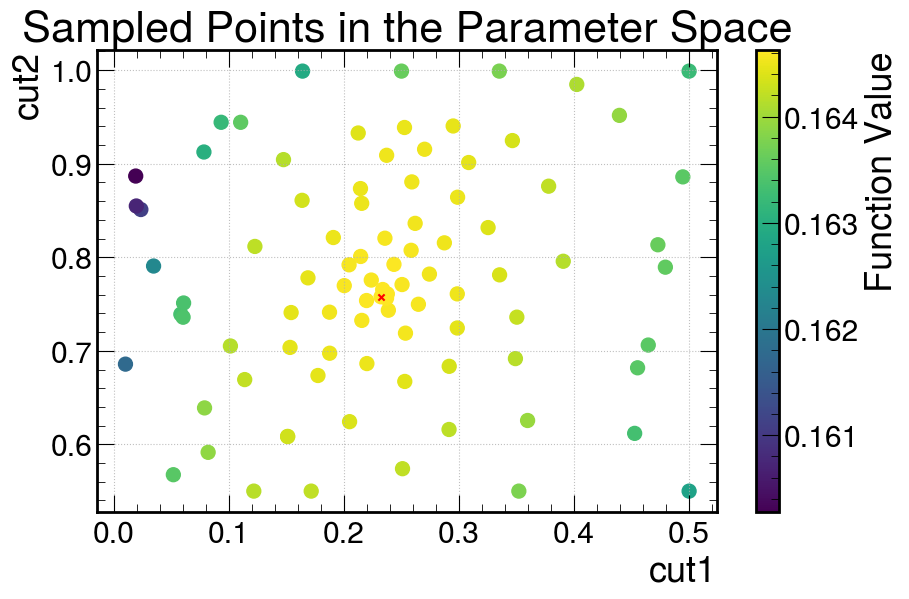

In [9]:
x_cut1 = []
x_cut2 = []
y_values = []

for res in optimizer.res:
    x_cut1.append(res["params"]["cut1"])
    x_cut2.append(res["params"]["cut2"])
    y_values.append(res["target"])

x_cut1 = np.array(x_cut1)
x_cut2 = np.array(x_cut2)
y_values = np.array(y_values)
# Plot the sampled points in the parameter space
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
scatter = ax.scatter(x_cut1, x_cut2, c=y_values, cmap='viridis', s=100)
ax.scatter(cut1, cut2, color='red', marker='x', s=20)
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Function Value')
ax.set_xlabel('cut1')
ax.set_ylabel('cut2')
ax.set_title('Sampled Points in the Parameter Space')
ax.grid(True)


### Use the optimized working points

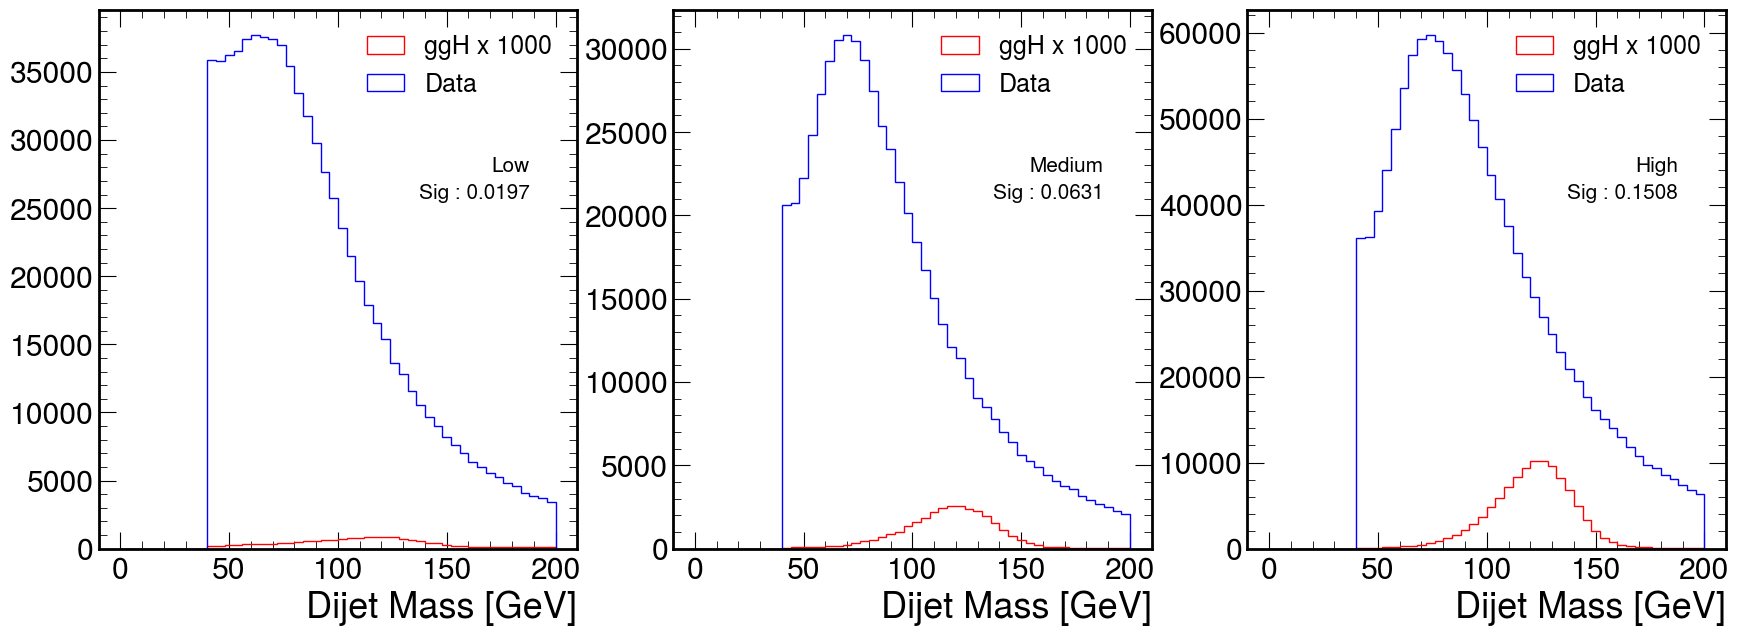

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))
bins = np.linspace(0, 200, 51)
ax[0].hist(df.dijet_mass[mLowS],       bins=bins, weights=df.weights[mLowS]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[0].hist(dfData.dijet_mass[mLowB],   bins=bins, histtype=u'step', color='blue', label='Data')

ax[1].hist(df.dijet_mass[mMediumS],       bins=bins, weights=df.weights[mMediumS]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[1].hist(dfData.dijet_mass[mMediumB],   bins=bins, histtype=u'step', color='blue', label='Data')

ax[2].hist(df.dijet_mass[mHighS],       bins=bins, weights=df.weights[mHighS]*1000, histtype=u'step', color='red', label='ggH x 1000')
ax[2].hist(dfData.dijet_mass[mHighB],   bins=bins, histtype=u'step', color='blue', label='Data')
for id,ax_ in enumerate(ax):
    ax_.set_xlabel("Dijet Mass [GeV]")
    ax_.legend(fontsize=18)
    ax_.text(x=0.9,y=0.7,s=["Low","Medium","High"][id], transform = ax_.transAxes, ha='right', fontsize=15)
    ax_.text(x=0.9,y=0.65,s="Sig : %.4f"%(np.round([mLowSig, mMediumSig, mHighSig][id], 4)), transform = ax_.transAxes, ha='right', fontsize=15)

### Combined

Regione Low-R1  Significanza: 0.0091
Regione Medium-R1  Significanza: 0.0202
Regione High-R1  Significanza: 0.0406
Regione Low-R2  Significanza: 0.0120
Regione Medium-R2  Significanza: 0.0260
Regione High-R2  Significanza: 0.0508
Regione Low-R3  Significanza: 0.0165
Regione Medium-R3  Significanza: 0.0553
Regione High-R3  Significanza: 0.1376

Matrice delle significanze:
[[0.00907403 0.02016029 0.04059932]
 [0.01202799 0.02595333 0.05083105]
 [0.01653305 0.05532121 0.13760332]]
Sig Total :  0.16675604100039443
Improvement :  1.1275743779831695


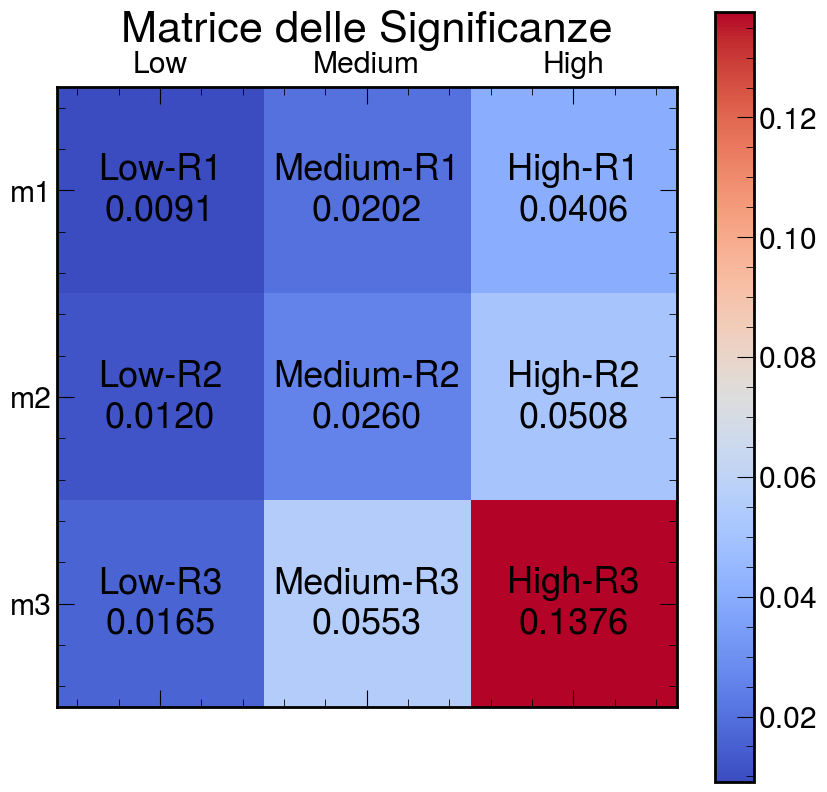

In [11]:

# Matrice per immagazzinare le significanze
sigMatrix = np.zeros((3, 3))

# Definizione della matrice delle combinazioni di maschere
masks_S = [[m1S & mLowS, m1S & mMediumS, m1S & mHighS],
              [m2S & mLowS, m2S & mMediumS, m2S & mHighS],
              [m3S & mLowS, m3S & mMediumS, m3S & mHighS]]

masks_B = [[m1B & mLowB, m1B & mMediumB, m1B & mHighB],
              [m2B & mLowB, m2B & mMediumB, m2B & mHighB],
              [m3B & mLowB, m3B & mMediumB, m3B & mHighB]]
labels =   [['Low-R1', 'Medium-R1', 'High-R1'],
            ['Low-R2', 'Medium-R2', 'High-R2'],
            ['Low-R3', 'Medium-R3', 'High-R3']]

# Calcolo delle significanze per ogni combinazione
for i in range(3):
    for j in range(3):
        sig_value = sig(df[masks_S[i][j]], dfData[masks_B[i][j]])
        sigMatrix[i, j] = sig_value
        print("Regione %s  Significanza: %.4f"%(labels[i][j], sig_value))

# Stampa della matrice di significanze
print("\nMatrice delle significanze:")
print(sigMatrix)
print("Sig Total : ", np.sqrt(np.sum(sigMatrix**2)))
print("Improvement : ", np.sqrt(np.sum(sigMatrix**2))/base_sig)


# Creazione della figura e dell'asse
fig, ax = plt.subplots()

# Plot della matrice con una colorbar
cax = ax.matshow(sigMatrix, cmap='coolwarm')

# Aggiunta della colorbar
plt.colorbar(cax)

# Aggiunta delle etichette e dei valori di significanza nelle celle
for i in range(3):
    for j in range(3):
        ax.text(j, i, f'{labels[i][j]}\n{sigMatrix[i, j]:.4f}', 
                ha='center', va='center', color='black')

# Impostazione dei ticks per gli assi
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))

# Impostazione delle etichette per gli assi
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_yticklabels(['m1', 'm2', 'm3'])

# Titolo del grafico
plt.title('Matrice delle Significanze')


# Se necessario, stampa anche i rapporti S/B per ogni regione
sb_ratios = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        sb_ratio_value = sb_ratio(df[masks_S[i][j]], dfData[masks_B[i][j]])
        sb_ratios[i, j] = sb_ratio_value

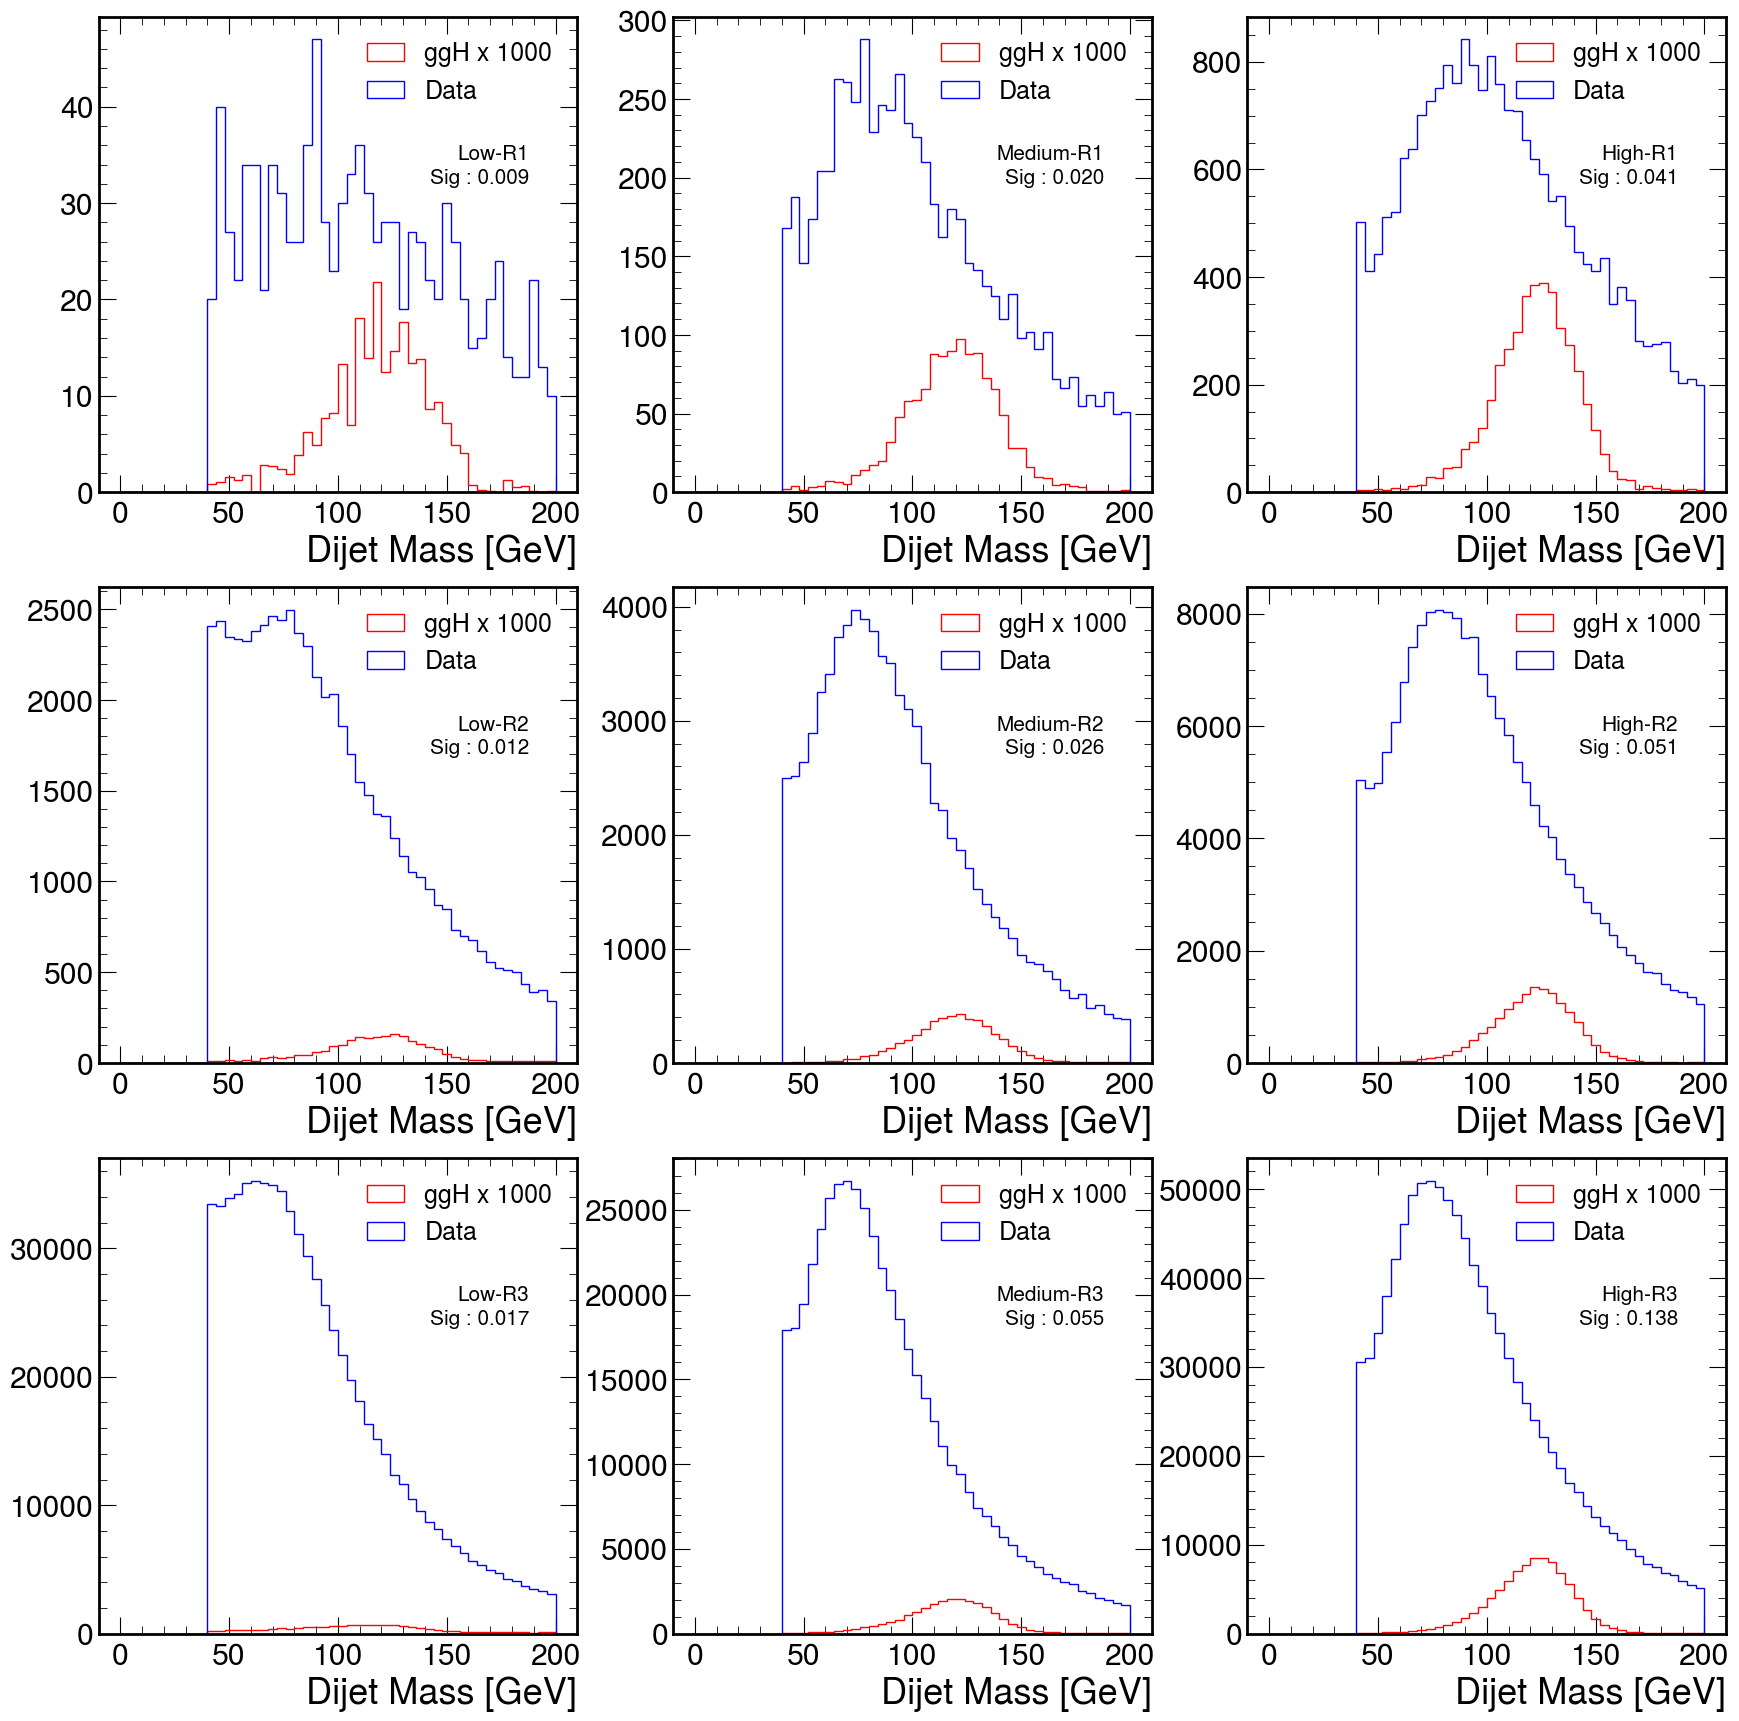

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(21,21))
bins = np.linspace(0, 200, 51)
for i in range(3):
    for j in range(3):
        sig_value = sig(df[masks_S[i][j]], dfData[masks_B[i][j]])
        
        
        ax[i,j].hist(df.dijet_mass[masks_S[i][j]],       bins=bins, weights=df.weights[masks_S[i][j]]*1000, histtype=u'step', color='red', label='ggH x 1000')
        ax[i,j].hist(dfData.dijet_mass[masks_B[i][j]],   bins=bins, histtype=u'step', color='blue', label='Data')



        ax[i,j].set_xlabel("Dijet Mass [GeV]")
        ax[i,j].legend(fontsize=18)
        ax[i,j].text(x=0.9,y=0.7,s=labels[i][j], transform = ax[i,j].transAxes, ha='right', fontsize=15)
        ax[i,j].text(x=0.9,y=0.65,s="Sig : %.3f"%(sig_value), transform = ax[i,j].transAxes, ha='right', fontsize=15)